# Question3

Build LSTM Model using Delta-rule

In [25]:
import numpy as np
import pandas as pd 
from tqdm.auto import trange
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [26]:
data='KERAS'
chars = list(set(data))

data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))

data has 5 characters, 5 unique


In [27]:
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

In [28]:
char_to_idx

{'A': 0, 'R': 1, 'K': 2, 'S': 3, 'E': 4}

In [29]:
idx_to_char

{0: 'A', 1: 'R', 2: 'K', 3: 'S', 4: 'E'}

### Parameters

In [30]:
# since we are using one word. data_size = char_size
data_size, char_size = len(data), len(chars)

print(data_size)
print(char_size)

5
5


In [31]:
hidden_size = 10
weight_sd = 0.1
z_size = hidden_size + char_size
t_steps = 25

### Activation Function

In [32]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

## Model

### Architecture

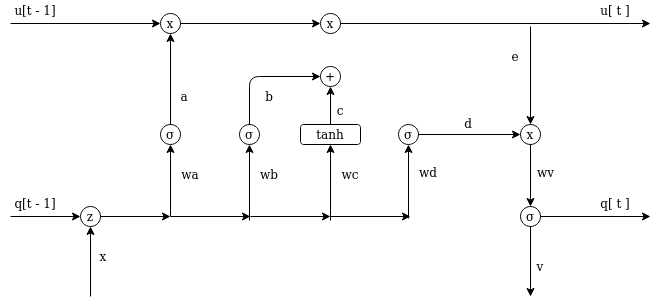

In [33]:
def forward(x, u, q):
    z = np.row_stack((q, x))

    a = sigmoid(np.dot(wa, z) + ba)
    b = sigmoid(np.dot(wb, z) + bb)
    c = tanh(np.dot(wc, z) + bc)
    d = sigmoid(np.dot(wd, z) + bd)

    e = a * u + b * c
    h = d * tanh(e)

    v = np.dot(wv, h) + bv
    y = np.exp(v) / np.sum(np.exp(v))

    return z, a, b, c, d, e, h, v, y

In [40]:
# optimizing using delta rule
def optimize(delta, theta, lr_rate =0.05):
    
    # delta
    dwa, dwb, dwc, dwd, dwv, dba, dbb, dbc, dbd, dbv = delta
    
    # theta
    wa, wb, wc, wd, wv, ba, bb, bc, bd, bv = theta
    
    # update weights
    wa -= dwa * lr_rate
    wb -= dwb * lr_rate
    wc -= dwc * lr_rate
    wd -= dwd * lr_rate
    wv -= dwv * lr_rate
    
    # bias
    ba -= dba * lr_rate
    bb -= dbb * lr_rate
    bc -= dbc * lr_rate
    bd -= dbd * lr_rate
    bv -= dbv * lr_rate
    
    return wa, wb, wc, wd, wv, ba, bb, bc, bd, bv

### Initilizae Variable

In [41]:
losses = {}
z, a, b, c, d, e, h, v, y = {}, {}, {}, {}, {}, {}, {}, {}, {}
q, x, u = {}, {}, {}

In [42]:
wa, wb, wc, wd = [np.random.randn(hidden_size, z_size) * weight_sd + 0.5 for x in range(4)]
ba, bb, bc, bd = [np.zeros((hidden_size, 1)) for x in range(4)]

# output
wv = np.random.randn(char_size, hidden_size) * weight_sd
bv = np.zeros((char_size, 1))

In [43]:
q[-1] = np.zeros((hidden_size, 1))
u[-1] = np.zeros((hidden_size, 1))

t_steps = 4

inputs = ([char_to_idx[ch] for ch in idx2char[0: t_steps]])
targets = ([char_to_idx[ch] for ch in idx2char[1: t_steps + 1]])

### Training

In [44]:
for epoch in range(2000):
    
    loss = 0
    
    # Forward propagation
    for t in range(len(inputs)):
        x[t] = np.zeros((char_size, 1))
        x[t][inputs[t]] = 1

        z[t], a[t], b[t], c[t], d[t], e[t], h[t], v[t], y[t] = forward(x[t], u[t - 1], q[t - 1])

        u[t], q[t] = e[t], h[t]

        loss += -np.log(y[t][targets[t], 0])


    dh_next = np.zeros_like(q[0])
    de_next = np.zeros_like(u[0])
    dwa, dwb, dwc, dwd, dwv, dba, dbb, dbc, dbd, dbv = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    # Backward propagation
    for t in reversed(range(len(inputs))):
        target = targets[t]

        dv = np.copy(y[t])
        dv[target] -= 1

        dwv += np.dot(dv, h[t].T)
        dbv += dv

        dh = np.dot(wv.T, dv)
        dh += dh_next

        dd = dh * tanh(e[t])
        dd = dsigmoid(d[t]) * dd

        dwd += np.dot(dd, z[t].T)
        dbd += dd

        de = np.copy(de_next)
        de += dh * d[t] * dtanh(tanh(e[t]))

        dc = de * b[t]
        dc = dtanh(c[t]) * dc

        dwc += np.dot(dc, z[t].T)
        dbc += dc

        db = de * dc
        db = dsigmoid(b[t]) * db

        dwb += np.dot(db, z[t].T)
        dbb += db

        da = de * u[t - 1]
        da = dsigmoid(a[t]) * da

        dwa += np.dot(da, z[t].T)
        dba += da

        dz = (np.dot(wa.T, da) 
              + np.dot(wb.T, db) 
              + np.dot(wc.T, dc) 
              + np.dot(dd.T, dd))

        dh_next = dz[:hidden_size, :]
        de_next = a[t] * de

    
    delta = dwa, dwb, dwc, dwd, dwv, dba, dbb, dbc, dbd, dbv
    theta = wa, wb, wc, wd, wv, ba, bb, bc, bd, bv

    # optimize with SGD the training data
    wa, wb, wc, wd, wv, ba, bb, bc, bd, bv = optimize(delta, theta)
        
    losses[epoch] = loss

### Analyze

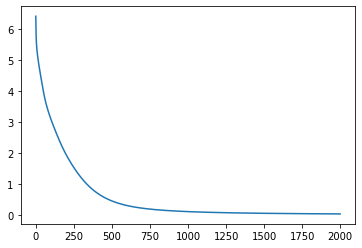

In [45]:
plt.plot(list(losses.keys()), [losses[x] for x in list(losses.keys())])

### Inference

In [46]:
inputs

[2, 4, 1, 0]

In [59]:
for t in range(len(inputs)):    
    x[t] = np.zeros((char_size, 1))
    x[t][inputs[t]] = 1

    print('INPUT:', idx_to_char[np.argmax(x[t])])
    
    z[t], a[t], b[t], c[t], d[t], e[t], h[t], v[t], y[t] = forward(x[t], u[t - 1], q[t - 1])
    
    # u: cell_state
    # q: hidden_state
    u[t], q[t] = e[t], h[t]
    
    y = [round(float(_),7) for _ in y[t]]
    
    print(f'>>> OUTPUT(Y): {y}')
    print('>>> OUTPUT(Alphabet):', idx_to_char[np.argmax(y)])
    print("==================================================")

INPUT: K
>>> OUTPUT(Y): [0.0007568, 0.0035026, 0.0002344, 2.3e-06, 0.9955038]
>>> OUTPUT(Alphabet): E
INPUT: E
>>> OUTPUT(Y): [0.0053674, 0.9899267, 0.0004291, 5.02e-05, 0.0042265]
>>> OUTPUT(Alphabet): R
INPUT: R
>>> OUTPUT(Y): [0.9885596, 0.0048662, 0.0002238, 0.0058953, 0.0004551]
>>> OUTPUT(Alphabet): A
INPUT: A
>>> OUTPUT(Y): [0.0056152, 9e-07, 3e-07, 0.9943836, 0.0]
>>> OUTPUT(Alphabet): S
